# MLP на PyTorch и автоматическое дифференцирование

## План семинара

### Часть I: PyTorch MLP
* Знакомство с PyTorch (базовые интерфейсы, broadcasting)
* Работа с данными (make_moons)
* Определение модели MLP на PyTorch
* Функции потерь и обучение
* Роль нелинейностей
* Сравнение с SVM
* Батчинг и эффективность

### Часть II: Autograd и Backpropagation
* Как работает автоматическое дифференцирование?
* Forward и backward pass
* Chain rule и backpropagation
* Примеры autograd в PyTorch
* Реализация собственного autograd

### Блиц-вопросы
* Проверка понимания материала

---

# Часть I: PyTorch MLP

## Знакомство с PyTorch

PyTorch - библиотека для глубокого обучения, разработанная Meta (Facebook).

**Основные преимущества:**
* Интуитивный API (похож на NumPy)
* Динамический computational graph
* Удобные инструменты для GPU
* Автоматическое дифференцирование

### Аналогия с NumPy

PyTorch tensors работают очень похоже на NumPy arrays:

In [21]:
import torch
import numpy as np

# NumPy
np_array = np.array([1, 2, 3, 4, 5])
print("NumPy array:", np_array)
print("Shape:", np_array.shape)
print("Mean:", np_array.mean())

print()

# PyTorch (очень похоже!)
torch_tensor = torch.tensor([1, 2, 3, 4, 5])
print("PyTorch tensor:", torch_tensor)
print("Shape:", torch_tensor.shape)
print("Mean:", torch_tensor.float().mean())  # PyTorch требует float для mean()

NumPy array: [1 2 3 4 5]
Shape: (5,)
Mean: 3.0

PyTorch tensor: tensor([1, 2, 3, 4, 5])
Shape: torch.Size([5])
Mean: tensor(3.)


### Основные операции с тензорами

In [22]:
# Создание тензоров
a = torch.zeros(3, 4)        # Матрица 3x4 из нулей
b = torch.ones(3, 4)         # Матрица 3x4 из единиц
c = torch.rand(3, 4)         # Случайные числа [0, 1)
d = torch.randn(3, 4)        # Нормальное распределение N(0, 1)

print("Zeros:\n", a)
print("\nOnes:\n", b)
print("\nRandom uniform:\n", c)
print("\nRandom normal:\n", d)

Zeros:
 tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]])

Ones:
 tensor([[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]])

Random uniform:
 tensor([[0.6057, 0.8140, 0.1160, 0.2760],
        [0.2885, 0.2483, 0.7573, 0.5793],
        [0.1443, 0.3085, 0.7692, 0.7457]])

Random normal:
 tensor([[ 1.7009,  0.8876, -0.9453, -0.6354],
        [ 0.9260,  0.1145, -1.3640,  0.1628],
        [ 0.7959,  0.3998, -1.6485,  0.1082]])


In [23]:
# Арифметические операции
x = torch.tensor([1.0, 2.0, 3.0])
y = torch.tensor([4.0, 5.0, 6.0])

print("x + y =", x + y)
print("x * y =", x * y)
print("x @ y =", x @ y)

x + y = tensor([5., 7., 9.])
x * y = tensor([ 4., 10., 18.])
x @ y = tensor(32.)


### Broadcasting в PyTorch

**Broadcasting** - механизм, позволяющий производить операции между тензорами разных размеров.

PyTorch автоматически "растягивает" тензоры меньшего размера, чтобы они совпадали по размерности.

**Правила broadcasting:**
1. Если тензоры имеют разное количество измерений, форма тензора с меньшим количеством измерений дополняется единицами слева
2. Размеры считаются совместимыми, если они равны или один из них равен 1
3. Тензоры расширяются по измерениям размером 1

Подробнее: [PyTorch Broadcasting Semantics](https://pytorch.org/docs/stable/notes/broadcasting.html)

In [25]:
# Пример 1: Вектор + скаляр
x = torch.tensor([1.0, 2.0, 3.0])  # shape: (3,)
scalar = 10.0                       # shape: ()

result = x + scalar
print("Вектор + скаляр:")
print(f"  {x.tolist()} + {scalar} = {result.tolist()}")
print(f"  Shapes: {x.shape} + () = {result.shape}")

print("\n\n")

# Пример 2: Матрица + вектор
matrix = torch.tensor([[1.0, 2.0, 3.0],
                        [4.0, 5.0, 6.0]])  # shape: (2, 3)
vector = torch.tensor([10.0, 20.0, 30.0])  # shape: (3,)

result = matrix + vector
print("Матрица + вектор:")
print("Matrix:\n", matrix)
print("Vector:", vector)
print("Result:\n", result)
print(f"Shapes: {matrix.shape} + {vector.shape} = {result.shape}")

Вектор + скаляр:
  [1.0, 2.0, 3.0] + 10.0 = [11.0, 12.0, 13.0]
  Shapes: torch.Size([3]) + () = torch.Size([3])



Матрица + вектор:
Matrix:
 tensor([[1., 2., 3.],
        [4., 5., 6.]])
Vector: tensor([10., 20., 30.])
Result:
 tensor([[11., 22., 33.],
        [14., 25., 36.]])
Shapes: torch.Size([2, 3]) + torch.Size([3]) = torch.Size([2, 3])


In [26]:
# Пример 3: Broadcasting в обе стороны
a = torch.tensor([[1.0],
                  [2.0],
                  [3.0]])  # shape: (3, 1)

b = torch.tensor([10.0, 20.0, 30.0])  # shape: (3,) → будет расширено до (1, 3)

result = a + b
print("Broadcasting в обе стороны:")
print("a (3, 1):\n", a)
print("b (3,):", b)
print("Result (3, 3):\n", result)
print(f"Shapes: {a.shape} + {b.shape} → {result.shape}")

Broadcasting в обе стороны:
a (3, 1):
 tensor([[1.],
        [2.],
        [3.]])
b (3,): tensor([10., 20., 30.])
Result (3, 3):
 tensor([[11., 21., 31.],
        [12., 22., 32.],
        [13., 23., 33.]])
Shapes: torch.Size([3, 1]) + torch.Size([3]) → torch.Size([3, 3])


### PyTorch vs NumPy: ключевые отличия

| Аспект | NumPy | PyTorch |
|--------|-------|---------|
| Основная структура | `ndarray` | `Tensor` |
| GPU поддержка | ❌ Нет | ✅ Да (`.cuda()`, `.to('cuda')`) |
| Autograd | ❌ Нет | ✅ Да (`.backward()`) |
| Создание | `np.array([1,2,3])` | `torch.tensor([1,2,3])` |
| Случайные числа | `np.random.rand(3,4)` | `torch.rand(3,4)` |
| Broadcasting | ✅ Да | ✅ Да (те же правила) |

**Когда использовать PyTorch вместо NumPy:**
* Нужно обучать нейросети (autograd!)
* Нужны вычисления на GPU
* Работаете с глубоким обучением

#  Данные

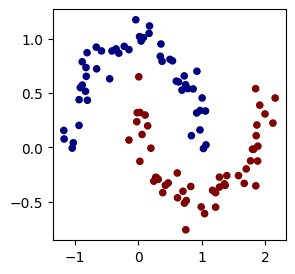

In [82]:
import numpy as np

from sklearn.datasets import make_moons, make_blobs
import matplotlib.pyplot as plt

X, y = make_moons(n_samples=100, noise=0.1, random_state=1)

plt.rcParams['figure.figsize'] = (3, 3)

# plt.figure(figsize=(5, 5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')



# Torch MLP

## Определяем модель

In [54]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# initialize a model
class MLP(nn.Module):
    def __init__(self, activation_cls=nn.ReLU):
        super().__init__()

        self.input_layer  = nn.Linear(2, 100)
        self.hidden_layer = nn.Linear(100, 100)
        self.output_layer = nn.Linear(100, 1)
        self.activation   = activation_cls()

        return

    def forward(self, x_coordinates):
        # x_coordinates ~ [ batch_size, 2 ]

        latents = self.activation(self.input_layer(x_coordinates))                  # [ batch_size, 100 ]
        latents = self.activation(self.hidden_layer(latents))      # [ batch_size, 100 ]
        scores = self.output_layer(latents)                        # [ batch_size, 1 ]
        scores = scores[:, 0]                                      # [ batch_size ]

        return scores


model = MLP()
print(model)
print("number of parameters", sum(p.numel() for p in model.parameters()))


MLP(
  (input_layer): Linear(in_features=2, out_features=100, bias=True)
  (hidden_layer): Linear(in_features=100, out_features=100, bias=True)
  (output_layer): Linear(in_features=100, out_features=1, bias=True)
  (activation): ReLU()
)
number of parameters 10501


In [55]:
print("Parameters shapes:")
print([p.shape for p in model.hidden_layer.parameters()])

Parameters shapes:
[torch.Size([100, 100]), torch.Size([100])]


In [56]:
list(model.parameters())

[Parameter containing:
 tensor([[ 3.1234e-01,  6.1994e-01],
         [-2.4248e-02,  4.8411e-01],
         [-1.8138e-01, -5.1720e-01],
         [ 3.2113e-01, -7.3071e-02],
         [ 4.5829e-01, -5.7123e-01],
         [ 3.4511e-01, -8.6600e-02],
         [ 6.4481e-01,  5.2571e-01],
         [ 4.6757e-01,  8.5680e-02],
         [ 5.7698e-03,  4.5764e-01],
         [-6.2306e-01, -2.8229e-01],
         [-2.5237e-01,  7.0369e-01],
         [ 5.6487e-01,  5.6051e-02],
         [-2.2266e-01,  3.8778e-01],
         [-6.2872e-01, -5.1454e-01],
         [ 5.1504e-01,  4.1069e-01],
         [-3.1669e-01,  1.3128e-01],
         [-3.4421e-01, -3.5449e-01],
         [-1.0391e-01, -6.4757e-01],
         [ 6.1123e-01, -1.0499e-01],
         [ 3.9898e-01, -5.4369e-01],
         [ 2.1647e-01, -4.2659e-01],
         [-1.2214e-01, -1.5520e-01],
         [-2.0117e-01,  2.1689e-01],
         [-2.4653e-01,  6.0392e-01],
         [ 5.5493e-01,  5.7744e-01],
         [ 1.2999e-01, -1.8801e-01],
         [ 2.32

## Вычисляем лосс

In [86]:

# loss function
def loss(model, Xbatch, ybatch):

    Xbatch = torch.tensor(Xbatch).float() # [ batch_size, 2 ]

    # ybatch.max() == 1, ybatch.min() == -1
    ybatch = torch.tensor(ybatch).float().unsqueeze(-1) # [ batch_size, 1 ]

    # forward the model to get scores
    model_prediction = model.forward(Xbatch).unsqueeze(-1) # [ batch_size, 1 ]

    # svm "max-margin" loss
    losses = F.relu(1 - ybatch * model_prediction) # [ batch_size, 1 ]
    loss = losses.mean()

    # L2 regularization
    alpha = 1e-4
    reg_loss = alpha * sum((p*p).sum() for p in model.parameters())
    total_loss = loss + reg_loss

    # also get accuracy
    accuracy = ((ybatch > 0) == (model_prediction > 0)).float().mean()
    return total_loss, accuracy

total_loss, acc = loss(model, X, y)
print(total_loss, acc)

tensor(0.9213, grad_fn=<AddBackward0>) tensor(0.5000)


In [87]:
# optimization

def train(model, learning_rate=0.1):

    Xbatch, ybatch = make_moons(n_samples=100, noise=0.1, random_state=1)
    ybatch = ybatch * 2 - 1 # make y be -1 or 1

    for k in range(500):

        model.zero_grad() # обнуляем градиенты с предыдущего шага

        # forward
        total_loss, acc = loss(model, Xbatch, ybatch)

        # backward
        total_loss.backward() # вычисляем новые значения градиентов
        # (model.linear_in.weight.grad)

        # шаг оптимизации
        # update (sgd)
        for p in model.parameters():
            p.data = p.data - learning_rate * p.grad

        if k % 50 == 0:
            print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")


model = MLP()

train(model, learning_rate=0.05)

step 0 loss 0.9976703524589539, accuracy 48.0%
step 50 loss 0.2845909297466278, accuracy 85.0%
step 100 loss 0.2447337657213211, accuracy 90.0%
step 150 loss 0.2083710879087448, accuracy 92.0%
step 200 loss 0.16348958015441895, accuracy 95.0%
step 250 loss 0.1146116629242897, accuracy 96.0%
step 300 loss 0.07182636111974716, accuracy 98.0%
step 350 loss 0.050044454634189606, accuracy 99.0%
step 400 loss 0.03948203846812248, accuracy 100.0%
step 450 loss 0.03334049880504608, accuracy 100.0%


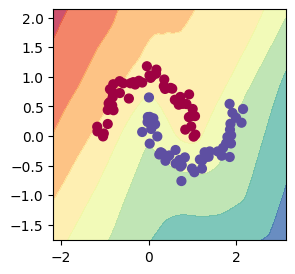

In [88]:
def visualize_model_prediction(model):

    h = 0.1
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                        np.arange(y_min, y_max, h))
    Xmesh = np.c_[xx.ravel(), yy.ravel()]

    if isinstance(model, nn.Module):
        with torch.no_grad():
            Xbatch = torch.tensor(Xmesh).float()

            scores = model.forward(Xbatch)
            Z = scores.numpy()

    else:
        scores = clf.decision_function(Xmesh)
        Z = scores

    Z = Z.reshape(xx.shape)

    fig = plt.figure()
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

visualize_model_prediction(model)

## Вклад нелинейностей



step 0 loss 1.0066101551055908, accuracy 50.0%
step 50 loss 0.8999418020248413, accuracy 50.0%
step 100 loss 0.5979681611061096, accuracy 80.0%
step 150 loss 0.3988984227180481, accuracy 81.0%
step 200 loss 0.3534523844718933, accuracy 84.0%
step 250 loss 0.32687675952911377, accuracy 85.0%
step 300 loss 0.30983299016952515, accuracy 85.0%
step 350 loss 0.2987881898880005, accuracy 87.0%
step 400 loss 0.2956525385379791, accuracy 88.0%
step 450 loss 0.2913205325603485, accuracy 87.0%


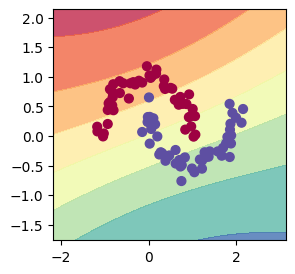

In [89]:
model = MLP(activation_cls=nn.Sigmoid)

train(model, learning_rate=0.1)
visualize_model_prediction(model)

step 0 loss 0.9899672269821167, accuracy 50.0%
step 50 loss 0.28781458735466003, accuracy 87.0%
step 100 loss 0.28761962056159973, accuracy 87.0%
step 150 loss 0.28734681010246277, accuracy 87.0%
step 200 loss 0.2873717248439789, accuracy 87.0%
step 250 loss 0.28734928369522095, accuracy 87.0%
step 300 loss 0.28723573684692383, accuracy 87.0%
step 350 loss 0.2872658371925354, accuracy 87.0%
step 400 loss 0.2872442603111267, accuracy 87.0%
step 450 loss 0.2872285544872284, accuracy 87.0%


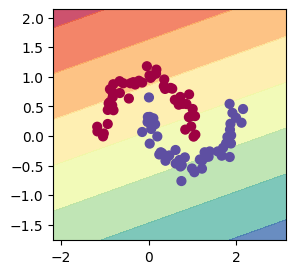

In [90]:
# nn.Identity(x) == x
model = MLP(activation_cls=nn.Identity)

train(model, learning_rate=0.1)
visualize_model_prediction(model)

# SVM

In [91]:
from sklearn.svm import LinearSVC, SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification


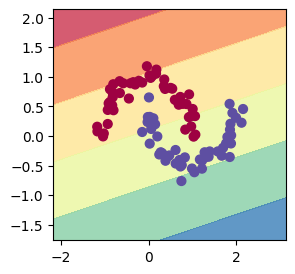

In [92]:
clf = LinearSVC(random_state=0)
clf.fit(X, y)
visualize_model_prediction(clf)

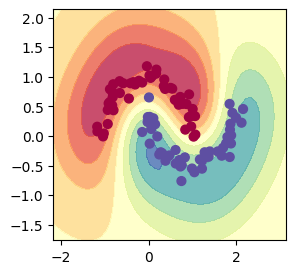

In [93]:
# визуализация SVM
# https://www.youtube.com/watch?v=OdlNM96sHio

clf = SVC(random_state=0, C=1.0, kernel='rbf')
clf.fit(X, y)
visualize_model_prediction(clf)

# Батчи и эффективность обучения / инференса

In [94]:
%%timeit

with torch.no_grad():
    Xbatch = torch.rand([1000, 2])
    model.forward(Xbatch)

160 µs ± 12.7 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [95]:
%%timeit

with torch.no_grad():
    Xbatch = torch.rand([1000, 2])
    for i in range(Xbatch.shape[0]):
        model.forward(Xbatch[i:i+1, :])

13.8 ms ± 465 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


---

# Часть II: Как работает автоматическое дифференцирование?

На первой части мы использовали PyTorch как "черный ящик". Мы вызывали `loss.backward()` и магическим образом получали градиенты для всех параметров модели.

Но как это работает? Давайте разберемся!

## Зачем мы пилим автоград? 🤖

Чтобы не считать градиенты вручную! Ведь количество вариаций, как может быть построен граф вычислений в нейросетях очень большое - заранее все формулы для градиентов мы не сможем посчитать.

## Что мы запомнили на лекции? 🤷

* нейросеть -- это сложная функция (с параметрами), которая может быть представлена как композиция простых функций
* оптимизируем с помощью градиентного спуска

Чтобы эффективно обучать нейросети, нам нужно автоматически вычислять градиенты по всем параметрам.

## Как работать с автоградом? 🪄

От автограда нам нужно 2 вещи: **forward** и **backward pass**.

### **forward pass**
На этом этапе идет вычисление выхода сети: подаем вход, прогоняем через все слои, получаем предсказание.

### **backward pass**
На этом этапе вычисляются градиенты: начинаем с loss функции и идем назад по сети, вычисляя градиенты по всем параметрам с помощью chain rule.

# Backpropagation + Chain rule = ❤️

**Chain rule (правило дифференцирования сложной функции)**:

Если $F = f(g(x))$, то $\frac{dF}{dx} = \frac{dF}{dg} \cdot \frac{dg}{dx}$

Пример:
\begin{align*}
F &= (a + b) c  \\
q &= a + b  \\
F &= q c
\end{align*}

Тогда:
\begin{align*}
\frac{\partial F}{\partial a} &= \frac{\partial F}{\partial q} \cdot \frac{\partial q}{\partial a} = c \cdot 1 = c \\
\frac{\partial F}{\partial b} &= \frac{\partial F}{\partial q} \cdot \frac{\partial q}{\partial b} = c \cdot 1 = c \\
\frac{\partial F}{\partial c} &= q
\end{align*}

**Backpropagation** - это просто применение chain rule для вычисления градиентов в нейросети!

---

# Матричное дифференцирование

При работе с нейросетями мы постоянно имеем дело с векторами и матрицами. Чтобы эффективно вычислять градиенты, нам нужно понимать правила матричного дифференцирования.


## Типы производных

В зависимости от того, что по чему дифференцируем, получаем разные объекты:

| Числитель | Знаменатель | Результат | Размерность | Название |
|-----------|-------------|-----------|-------------|----------|
| Скаляр $y$ | Вектор $\mathbf{x} \in \mathbb{R}^n$ | Вектор | $n \times 1$ | Градиент |
| Вектор $\mathbf{y} \in \mathbb{R}^m$ | Вектор $\mathbf{x} \in \mathbb{R}^n$ | Матрица | $m \times n$ | Якобиан |
| Скаляр $y$ | Матрица $W \in \mathbb{R}^{m \times n}$ | Матрица | $m \times n$ | Градиент |


## Основные правила матричного дифференцирования

### 1. Линейные операции

**Производная линейной формы:**
$$\frac{\partial (\mathbf{a}^T \mathbf{x})}{\partial \mathbf{x}} = \mathbf{a}$$

где $\mathbf{a}$ — константный вектор, $\mathbf{x}$ — переменная.



### 2. Матрично-векторное умножение

**Производная по вектору:**
$$\frac{\partial (W\mathbf{x})}{\partial \mathbf{x}} = W^T$$

**Производная по матрице:**
$$\frac{\partial (\mathbf{a}^T W \mathbf{x})}{\partial W} = \mathbf{a} \mathbf{x}^T$$

где результат — матрица размера $m \times n$ (внешнее произведение векторов).


In [96]:
# Пример: градиенты линейного слоя в PyTorch
import torch

# Создаем данные
x = torch.randn(5, requires_grad=True)  # вход: вектор размера 5
W = torch.randn(3, 5, requires_grad=True)  # веса: матрица 3x5
b = torch.randn(3, requires_grad=True)  # bias: вектор размера 3

# Forward pass
z = W @ x + b  # z = Wx + b
z_loss = z.sum()  # простая функция потерь (сумма элементов)

# Backward pass
z_loss.backward()

print("Градиент по W:")
print(f"  Shape: {W.grad.shape}")
print(f"  Вычисляется как: dL/dz * x^T")
print()
print("Градиент по x:")
print(f"  Shape: {x.grad.shape}")
print(f"  Вычисляется как: W^T * dL/dz")
print()
print("Градиент по b:")
print(f"  Shape: {b.grad.shape}")
print(f"  Равен dL/dz")

Градиент по W:
  Shape: torch.Size([3, 5])
  Вычисляется как: dL/dz * x^T

Градиент по x:
  Shape: torch.Size([5])
  Вычисляется как: W^T * dL/dz

Градиент по b:
  Shape: torch.Size([3])
  Равен dL/dz


### Пример 2: Mean Squared Error (MSE)

Функция потерь: $L = \frac{1}{n} \|\mathbf{y}_{pred} - \mathbf{y}_{true}\|^2 = \frac{1}{n} \sum_{i=1}^n (y_{pred}^{(i)} - y_{true}^{(i)})^2$

**Градиент по предсказаниям:**
$$\frac{\partial L}{\partial \mathbf{y}_{pred}} = \frac{2}{n}(\mathbf{y}_{pred} - \mathbf{y}_{true})$$

Это показывает, что градиент направлен в сторону увеличения ошибки, и при обучении мы движемся в противоположную сторону (gradient descent).

In [69]:
# Проверяем градиент MSE
y_pred = torch.randn(10, requires_grad=True)
y_true = torch.randn(10)

# MSE loss
loss = ((y_pred - y_true) ** 2).mean()
loss.backward()

print("Предсказания:", y_pred.data[:5])
print("Истинные значения:", y_true[:5])
print("Градиент:", y_pred.grad[:5])
print()
print("Формула: dL/dy_pred = 2/n * (y_pred - y_true)")
manual_grad = 2 * (y_pred.data - y_true) / len(y_pred)
print("Ручной расчет:", manual_grad[:5])
print("Совпадает с PyTorch:", torch.allclose(y_pred.grad, manual_grad))

Предсказания: tensor([-1.7647, -0.8636,  1.6340,  1.3881,  0.5012])
Истинные значения: tensor([ 1.1041, -0.9428,  0.8048,  0.7661,  0.4751])
Градиент: tensor([-0.5738,  0.0158,  0.1658,  0.1244,  0.0052])

Формула: dL/dy_pred = 2/n * (y_pred - y_true)
Ручной расчет: tensor([-0.5738,  0.0158,  0.1658,  0.1244,  0.0052])
Совпадает с PyTorch: True


## Зачем это нужно?

1. **Понимание backpropagation**: Все градиенты в нейросетях вычисляются по этим правилам
2. **Оптимизация**: Знание формул помогает писать эффективный код
3. **Отладка**: Можно проверить правильность градиентов вручную
4. **Создание своих слоев**: При реализации custom layers нужно знать, как вычислять градиенты

## Полезные ресурсы

- [The Matrix Calculus You Need For Deep Learning](https://explained.ai/matrix-calculus/) — подробный туториал
- [Matrix Cookbook](https://www.math.uwaterloo.ca/~hwolkowi/matrixcookbook.pdf) — справочник формул
- [CS231n: Backpropagation](https://cs231n.github.io/optimization-2/) — объяснение backprop с примерами
- [PyTorch Autograd](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html) — как PyTorch вычисляет градиенты

# Рассмотрим пример, как работает autograd в PyTorch

In [70]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import random
import torch.nn as nn
import torch

### Как на градиенты влияет сложение?

\begin{align*}
c &= a + b \\
\frac {\partial c} {\partial a} &= 1 \\
\frac {\partial c} {\partial b} &= 1
\end{align*}

### Как на градиенты влияет умножение?

\begin{align*}
c &= a \cdot b \\
\frac {\partial c} {\partial a} &= b \\
\frac {\partial c} {\partial b} &= a
\end{align*}

In [71]:
a = torch.Tensor([10.])
a.requires_grad = True

b = torch.Tensor([10.])
b.requires_grad = True

с = a * b
с.backward()

a.grad, b.grad

(tensor([10.]), tensor([10.]))

# Мы готовы сделать свой автоград!

## ReLU (Rectified Linear Unit)

В семинаре мы будем использовать ReLU в качестве функции активации:

$$
\text{ReLU}(x) = \max(0, x)
$$

Производная ReLU:

$$
\frac{d \text{ReLU}}{dx} = \begin{cases} 1, & x > 0 \\ 0, & x \leq 0 \end{cases}
$$

### Python magic methods

Python позволяет переопределять операторы через magic methods:

```python
Value(1) + Value(2)
# превращается в
Value(1).__add__(Value(2))
```

Мы будем использовать это, чтобы автоматически строить computational graph!

### Closures (замыкания)

Замыкание - это функция, которая "запоминает" переменные из внешней области видимости.

```python
def make_adder(x):
    def adder(y):
        return x + y  # x "запомнили" из внешней функции
    return adder

add_5 = make_adder(5)
print(add_5(10))  # 15
```

Мы будем использовать замыкания для хранения градиентных функций!

## Класс Value - наш автоград

In [72]:
class Value:
    """Класс для автоматического дифференцирования."""

    def __init__(self, data, _children=(), _op=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op

    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += out.grad  # d(a+b)/da = 1
            other.grad += out.grad  # d(a+b)/db = 1
        out._backward = _backward

        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad  # d(a*b)/da = b
            other.grad += self.data * out.grad  # d(a*b)/db = a
        out._backward = _backward

        return out

    def relu(self):
        out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')

        def _backward():
            self.grad += (out.data > 0) * out.grad  # производная ReLU
        out._backward = _backward

        return out

    def backward(self):
        """Запускает backpropagation от этого узла."""
        # Топологическая сортировка
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)

        # Идем от выхода к входу и вычисляем градиенты
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

### Пример использования нашего autograd

In [73]:
# Пример: вычислим f(x, y) = (x + y) * x и его градиенты
x = Value(2.0)
y = Value(3.0)

z = x + y  # z = 5
f = z * x  # f = 10

print(f"f = {f.data}")

# Вычисляем градиенты
f.backward()

print(f"df/dx = {x.grad}")  # Должно быть: df/dx = z + x = 5 + 2 = 7
print(f"df/dy = {y.grad}")  # Должно быть: df/dy = x = 2

f = 10.0
df/dx = 7.0
df/dy = 2.0


---

# Блиц-вопросы

## Часть I: PyTorch и MLP

1. В чем главное отличие PyTorch от NumPy?

2. Что такое broadcasting? Приведите пример.

3. Как луны может разделить логистическая регрессия?

4. Чем наша реализация MLP отличается от LinearSVC?

5. Как `learning_rate` влияет на скорость обучения? Что будет с очень маленьким lr=1e-8? С очень большим lr=1e3?

6. Что будет, если убрать все нелинейности из нашей модели?

7. Что такое батч? Почему вычисления в нейросетях батчуются?


## Часть II: Autograd и Backpropagation

1. Зачем нужны функции активации в нейросетях?

2. Зачем нужен autograd? Почему нельзя вычислять градиенты вручную?

3. Когда вычисляются градиенты - во время forward или backward pass?

4. Какие градиенты нам нужны для обучения нейросети и зачем?

5. Как computational graph, построенный во время forward pass, используется при backward pass?

6. Как сложение и умножение влияют на градиенты?

7. Какой правильный порядок шагов при обучении нейросети?
   - a) forward → backward → zero_grad → optimizer.step
   - b) zero_grad → forward → backward → optimizer.step
   - c) backward → forward → zero_grad → optimizer.step

---

## Дополнительные материалы

* [PyTorch Documentation](https://pytorch.org/docs/stable/index.html)
* [PyTorch Tutorials](https://pytorch.org/tutorials/)
* [PyTorch Broadcasting Semantics](https://pytorch.org/docs/stable/notes/broadcasting.html)
* [Backpropagation Calculus](https://www.youtube.com/watch?v=tIeHLnjs5U8) - отличное видео от 3Blue1Brown
* [micrograd](https://github.com/karpathy/micrograd) - минималистичный autograd engine от Andrej Karpathy

---

# Домашка и квиз

Отправлю все в чат курса.

Квизы нужно пройти, чтобы получить допуск на экзамен. Квизы сейчас в тестовом режиме первое занятие - первый год проводим их, надо все отладить, проверить, что все работает как было задумано.